# Essential dynamics

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from torch.nn import functional as F
from sklearn.manifold import TSNE
import gc
import itertools
from scipy.ndimage import gaussian_filter1d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import numpy as np
import tqdm

# import sys
# del sys.modules['icl.figures.colors']
# del sys.modules['icl.figures.notation']

from devinterp.slt.forms import get_osculating_circle
from icl.analysis.utils import get_unique_run
from icl.constants import ANALYSIS, FIGURES, SWEEPS, DATA
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import (
    plot_transitions,
    gen_transition_colors,
    get_transition_type,
    PRIMARY,
    SECONDARY,
    TERTIARY,
    BRED,
    BBLUE,
    BRED,
    BGREEN,
)
from icl.constants import DEVICE

# from devinterp.slt.forms import
sns.set_style("white")
DEVICE

plt.rcParams["figure.dpi"] = 300

In [3]:
NUM_TASKS = "inf"
NUM_LAYERS = 2
MAX_LR = 0.003
MODEL_SEED = 0
MODEL_ID = f"L2H4Minf{MODEL_SEED}"

os.makedirs(str(FIGURES / MODEL_ID), exist_ok=True)

BATCH_SIZE = 8192
K = 8
D = 4

run = get_unique_run(
    str(SWEEPS / "regression/training-runs/L2H4Minf.yaml"),
    task_config={
        "num_tasks": NUM_TASKS,
        "num_layers": NUM_LAYERS,
        "model_seed": MODEL_SEED,
    },
    optimizer_config={"lr": MAX_LR},
)

/Users/Jesse/Projects/icl/src/icl/regression/baselines.py:165: UserWarning:

The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)



In [4]:
from infra.utils.iterables import int_linspace
from copy import deepcopy
from pathlib import Path

steps = int_linspace(0, 500_000, 10_000)[::2]
# steps

In [5]:
if os.path.exists(Path("../checkpoints") / f"{MODEL_ID}-models.pt"):
    print("Loading models from disk")
    models = torch.load(Path("../checkpoints") / f"{MODEL_ID}-models.pt")
    optimizer_state_dicts = torch.load(
        Path("../checkpoints") / f"{MODEL_ID}-optimizer_state_dicts.pt"
    )

else:
    print("Retrieving models from AWS")
    # Let's generate these same plots and also look at their evolution.
    models = []
    optimizer_state_dicts = []

    for step in tqdm.tqdm(steps):
        checkpoint = run.checkpointer.load_file(step)

        m = deepcopy(run.model)
        m.load_state_dict(checkpoint["model"])
        models.append(m)
        optimizer_state_dicts.append(checkpoint["optimizer"])

    print("Saving models to disk")
    torch.save(models, Path("../checkpoints") / f"{MODEL_ID}-models.pt")
    torch.save(
        optimizer_state_dicts,
        Path("../checkpoints") / f"{MODEL_ID}-optimizer_state_dicts.pt",
    )

Loading models from disk


In [6]:
from icl.regression.model import to_token_sequence, from_predicted_token_sequence

K = 16
B = 1024
D = 4

torch.manual_seed(0)

xs, ys, ws = run.pretrain_dist.get_batch(K, B, return_ws=True)
tokens = to_token_sequence(xs, ys)
tokens.shape

losses = []

for i, m in enumerate(tqdm.tqdm(models)):
    with torch.no_grad():
        yhats = m(xs, ys)
        loss = F.mse_loss(yhats, ys)
        losses.append(loss.item())

losses = np.array(losses)

100%|██████████| 5000/5000 [00:31<00:00, 156.66it/s]


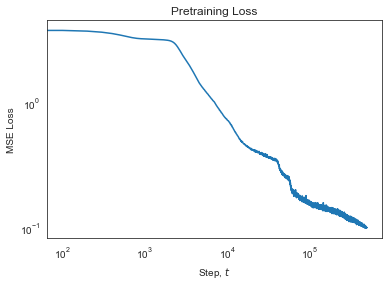

In [7]:
plt.plot(steps, losses - losses.min() + 1e-1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Step, $t$")
plt.ylabel("MSE Loss")
plt.title("Pretraining Loss")
plt.show()

In [8]:
import pickle

outputs = np.zeros((len(models), K * B * (D + 1) * 2), dtype=np.float32)
# min_outputs = torch.zeros(len(models), dtype=torch.float32)

FORCE_REEVAL = False

if not os.path.exists(DATA / f"{MODEL_ID}-outputs.pkl") or FORCE_REEVAL:
    print("Computing outputs")
    for i, model in enumerate(tqdm.tqdm(models, desc="Computing outputs")):
        with torch.no_grad():
            output = model.token_sequence_transformer(tokens).flatten()
            outputs[i, :] = output.cpu().numpy()
            # print(i, outputs[i])
            # min_outputs[i] = output.abs().min()
            # output /= min_outputs[i]
    with open(DATA / f"{MODEL_ID}-outputs.pkl", "wb") as f:
        pickle.dump(outputs, f)
else:
    print("Loading outputs from disk")
    with open(DATA / f"{MODEL_ID}-outputs.pkl", "rb") as f:
        outputs = pickle.load(f)
        

Loading outputs from disk


In [9]:
def get_outputs(models, xs, ys, model_id, force_reeval=False):
    B, K, D = xs.shape

    outputs = np.zeros((len(models), K * B), dtype=np.float32)

    if not os.path.exists(DATA / f"{model_id}-outputs-y-only.pkl") or force_reeval:
        print("Computing outputs")
        for i, model in enumerate(tqdm.tqdm(models, desc="Computing outputs")):
            with torch.no_grad():
                output = model(xs, ys).flatten()
                outputs[i, :] = output.cpu().numpy()

        with open(DATA / f"{model_id}-outputs-y-only.pkl", "wb") as f:
            pickle.dump(outputs, f)
    else:
        print("Loading outputs from disk")
        with open(DATA / f"{model_id}-outputs-y-only.pkl", "rb") as f:
            outputs = pickle.load(f)

    return outputs

y_outputs = get_outputs(models, xs, ys, model_id=MODEL_ID, force_reeval=FORCE_REEVAL)

Loading outputs from disk


In [10]:
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns

cmap = sns.color_palette("Spectral", as_cmap=True)
color_indices = np.linspace(0, 1, len(models))
colors = np.array([cmap(c) for c in color_indices])
colors

array([[0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.61960784, 0.00392157, 0.25882353, 1.        ],
       ...,
       [0.36862745, 0.30980392, 0.63529412, 1.        ],
       [0.36862745, 0.30980392, 0.63529412, 1.        ],
       [0.36862745, 0.30980392, 0.63529412, 1.        ]])

In [11]:
NUM_COMPONENTS = 4

pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(outputs)
pca_outputs = pca.transform(outputs)
pca_outputs.shape

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    pca_outputs,
    labels=labels,
    dimensions=range(NUM_COMPONENTS),
)

fig.update_traces(diagonal_visible=True, marker=dict(size=1.5, color=colors))
fig.update_layout(width=200 * NUM_COMPONENTS, height=150 * NUM_COMPONENTS)  # Adjust the size as needed
fig.update_layout(title_text=f"ED (Unnormalized samples, no smoothing)")

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / "pca.html"))

fig.show()

In [12]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
outputs_normalized = (outputs - outputs.mean(axis=0)) / outputs.std(axis=0)
pca.fit(outputs_normalized)
pca_outputs_normalized = pca.transform(outputs_normalized)
pca_outputs_normalized.shape

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    pca_outputs_normalized,
    labels=labels,
    dimensions=range(10),
)
fig.update_traces(diagonal_visible=True, marker=dict(size=1.5, color=colors))
fig.update_layout(width=2000, height=1500)  # Adjust the size as needed
fig.update_layout(title_text=f"ED (Normalized samples, no smoothing)")

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / "pca_normalized.html"))

fig.show()

ValueError: Value of 'dimensions_4' is not the name of a column in 'data_frame'. Expected one of [0, 1, 2, 3] but received: 4

In [ ]:
pca = PCA(n_components=10)
pca.fit(outputs.astype(np.float16))
pca_outputs = pca.transform(outputs)
pca_outputs.shape

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    pca_outputs,
    labels=labels,
    dimensions=range(10),
)

fig.update_traces(diagonal_visible=True, marker=dict(size=1.5, color=colors))
fig.update_layout(width=2000, height=1500)  # Adjust the size as needed
fig.update_layout(title_text=f"ED (Unnormalized samples, no smoothing, float16)")

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / "pca-f16.html"))

fig.show()

# Role of Sample count

### All outputs

In [27]:
NUM_COMPONENTS = 4

for subsample in tqdm.tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]):
    pca = PCA(n_components=NUM_COMPONENTS)
    pca.fit(outputs[::subsample])
    pca_outputs = pca.transform(outputs)
    pca_outputs.shape

    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    fig = px.scatter_matrix(
        pca_outputs,
        labels=labels,
        dimensions=range(NUM_COMPONENTS),
    )

    fig.update_traces(diagonal_visible=True, marker=dict(size=1.5, color=colors))
    fig.update_layout(width=200 * NUM_COMPONENTS, height=150 * NUM_COMPONENTS)  # Adjust the size as needed
    fig.update_layout(title_text=f"ED (Unnormalized samples, no smoothing, subsampled by {subsample})")

    pyo.plot(fig, filename=str(FIGURES / MODEL_ID / f"pca-sub-{subsample}.html"))
    fig.write_image(str(FIGURES / MODEL_ID / f"pca-sub-{subsample}.png"))

# fig.show()

  0%|          | 0/10 [00:10<?, ?it/s]


KeyboardInterrupt: 

### Only ys

In [14]:
NUM_COMPONENTS = 4

for subsample in tqdm.tqdm([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]):
    pca = PCA(n_components=NUM_COMPONENTS)
    pca.fit(y_outputs[::subsample, ])
    pca_y_outputs = pca.transform(y_outputs)
    pca_y_outputs.shape

    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }

    fig = px.scatter_matrix(
        pca_y_outputs,
        labels=labels,
        dimensions=range(NUM_COMPONENTS),
    )

    fig.update_traces(diagonal_visible=True, marker=dict(size=1.5, color=colors))
    fig.update_layout(width=200 * NUM_COMPONENTS, height=150 * NUM_COMPONENTS)  # Adjust the size as needed
    fig.update_layout(title_text=f"ED (Unnormalized samples, no smoothing, subsampled by {subsample}, only ys)")

    # pyo.plot(fig, filename=str(FIGURES / MODEL_ID / f"pca-sub-{subsample}-only-y.html"))
    fig.write_image(str(FIGURES / MODEL_ID / f"pca-sub-{subsample}-only-y.png"))

# fig.show()

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


: 

# Smoothing

I want to understand the role of the smoothing. 

Since we expect developmental time to not be the same as SGD time, we want the smoothing to vary with the timestep.

As a start, I'll look at the following learning rate schedules:

- Constant
- Linear increase
- Square root increase
- Logarithmic increase

For each, I'll examine the effect of changing the initial and final smoothing strengths. 

I also want to examine the effect of applying smoothing before or after PCA.

We'll start by looking at constant smoothing, and use this information to deduce appropriate initial and final smoothing strengths for the other schedules.

## Constant Gaussian smoothing

In [ ]:
def to_color_string(color):
    # return (256 * color[0], 256 * color[1], 256 * color[2], color[3])
    return f"rgb({int(256 * color[0])}, {int(256 * color[1])}, {int(256 * color[2])}, {color[3]})"


def smoothed_ed(
    outputs,
    smooth_fn,
    *args,
    num_pcs=3,
    pre=True,
    title="PCA Analysis with Variable Smoothing",
    filename=None,
):
    pc_combos = list(itertools.combinations(range(num_pcs), 2))
    num_pc_plots = len(pc_combos)
    num_smoothings = len(args[0])

    subplot_titles = [f"Smoothing: {smooth:.2f}" for smooth in args[0]]

    # Setup plotly subplots grid
    fig = make_subplots(
        rows=len(pc_combos), cols=num_smoothings, subplot_titles=subplot_titles
    )

    cmap1 = sns.color_palette("Spectral", as_cmap=True)
    cmap2 = sns.color_palette("viridis", as_cmap=True)
    colors1 = np.array(
        [to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(models))]
    )

    # Add osculating circles and centers
    min_ts, max_ts = 2, len(models) - 2
    ts = np.array(range(min_ts, max_ts))
    centers = np.zeros((len(ts), 2))
    colors2 = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(ts))])

    for c, smoothings in enumerate(tqdm.tqdm(zip(*args), total=len(args[0]))):
        outputs_smoothed = outputs
        if pre:
            outputs_smoothed = smooth_fn(outputs, *smoothings, axis=0)

        pca = PCA(n_components=num_pcs)
        pca.fit(outputs_smoothed)

        # Transform & plot the unsmoothed data using the smoothed PCA.
        # This is the same as the PCA of the raw data if using post-smoothing
        _pca_outputs_smoothed = pca.transform(outputs_smoothed)
        _pca_outputs = pca.transform(outputs)

        if not pre:
            _pca_outputs_smoothed = smooth_fn(
                _pca_outputs_smoothed, *smoothings, axis=0
            )

        for r, (pc1, pc2) in enumerate(pc_combos):
            row, col = r + 1, c + 1

            # Plot unsmoothed data
            fig.add_trace(
                go.Scatter(
                    x=_pca_outputs[:, pc1],
                    y=_pca_outputs[:, pc2],
                    mode="markers",
                    marker=dict(color=colors1, size=2),
                    name=f"Original Data {c}",
                ),
                row=row,
                col=col,
            )

            for i, t in enumerate(ts):
                center, radius = get_osculating_circle(
                    _pca_outputs_smoothed[:, (pc1, pc2)], t
                )
                if t in np.logspace(0, np.log10(len(ts)), 500, base=10).astype(int):
                    # This seems to be cheaper than directly plotting a circle
                    circle = go.Scatter(
                        x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                        y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                        mode="lines",
                        line=dict(color="rgba(0,0,0, 0.05)", width=1),
                        showlegend=False,
                    )
                    fig.add_trace(circle, row=row, col=col)

                centers[i] = center

            # Scatter plot for PCA outputs
            fig.add_trace(
                go.Scatter(
                    x=_pca_outputs_smoothed[:, pc1],
                    y=_pca_outputs_smoothed[:, pc2],
                    mode="lines",
                    line=dict(color="rgb(0,0,0,0.5)", width=2),
                    name=f"Original Data {c}",
                ),
                row=row,
                col=col,
            )

            # Scatter plot for centers
            fig.add_trace(
                go.Scatter(
                    x=centers[:, 0],
                    y=centers[:, 1],
                    mode="markers",
                    marker=dict(color=colors2, size=2, symbol="x"),
                    name="Centers",
                ),
                row=row,
                col=col,
            )

            xmin, xmax = (
                _pca_outputs_smoothed[:, pc1].min(),
                _pca_outputs_smoothed[:, pc1].max(),
            )
            ymin, ymax = (
                _pca_outputs_smoothed[:, pc2].min(),
                _pca_outputs_smoothed[:, pc2].max(),
            )
            fig.update_xaxes(
                range=(xmin * 1.25, xmax * 1.25),
                row=row,
                col=col,
                title=dict(text=f"PC {pc1 + 1}"),
            )
            fig.update_yaxes(
                range=(ymin * 1.25, ymax * 1.25),
                row=row,
                col=col,
                title=dict(text=f"PC {pc2 + 1}"),
            )

    fig.update_layout(
        height=num_pc_plots * 500,
        width=num_smoothings * 500,
        title_text=title,
        showlegend=False,
    )
    if filename:
        pyo.plot(fig, filename=filename, auto_open=True)
    else:
        fig.show()


def constant_smooth(outputs, smoothing: float, axis=0, mode="nearest", **kwargs):
    outputs_smoothed = outputs.copy()
    if smoothing != 0:
        outputs_smoothed = gaussian_filter1d(
            outputs, smoothing, axis=axis, mode=mode, **kwargs
        )

    return outputs_smoothed


num_smoothings = 10

smoothings = np.logspace(-2, 2, num_smoothings, base=10)
smoothed_ed(
    outputs,
    constant_smooth,
    smoothings,
    num_pcs=3,
    pre=False,
    title="Constant smoothing (Post-PCA, Unnormalized)",
    filename=str(FIGURES / MODEL_ID / "ed-constant-postsmoothing.html"),
)

smoothings = np.logspace(-2, 2, num_smoothings, base=10)
smoothed_ed(
    outputs,
    constant_smooth,
    smoothings,
    num_pcs=3,
    pre=True,
    title="Constant smoothing (Pre-PCA, Unnormalized)",
    filename=str(FIGURES / MODEL_ID / "ed-constant-presmoothing.html"),
)

smoothings = np.logspace(-2, 2, num_smoothings, base=10)
smoothed_ed(
    outputs_normalized,
    constant_smooth,
    smoothings,
    num_pcs=3,
    pre=False,
    title="Constant smoothing (Post-PCA, Normalized)",
    filename=str(FIGURES / MODEL_ID / "ed-constant-postsmoothing-normalized.html"),
)

smoothings = np.logspace(-2, 2, num_smoothings, base=10)
smoothed_ed(
    outputs_normalized,
    constant_smooth,
    smoothings,
    num_pcs=3,
    pre=True,
    title="Constant smoothing (Pre-PCA, Normalized)",
    filename=str(FIGURES / MODEL_ID / "ed-constant-presmoothing-normalized.html"),
)

Based on these charts, we can gauge the minimum required smoothing strength at the start and end. 

Given this information, we now investigate different schedules for increasing the smoothing strength.

In [ ]:
from icl.analysis.smoothing import gaussian_filter1d_variable_sigma, _gaussian_kernel1d

In [ ]:
def smoothed_ed_schedule(
    outputs,
    *smooth_fns,
    start,
    end,
    num_pcs=3,
    pre=True,
    title="PCA Analysis with Variable Smoothing",
    filename=None,
):
    pc_combos = list(itertools.combinations(range(num_pcs), 2))
    num_pc_plots = len(pc_combos)
    num_smooth_fns = len(smooth_fns)

    # Setup plotly subplots grid
    subplot_titles = [f"Smoothing: {smooth_fn.__name__}" for smooth_fn in smooth_fns]
    fig = make_subplots(
        rows=len(pc_combos), cols=num_smooth_fns, subplot_titles=subplot_titles
    )

    colors = (
        px.colors.sequential.Rainbow
    )  # or use px.colors.sequential.Jet for a different colormap

    for c, smooth_fn in enumerate(tqdm.tqdm(smooth_fns)):
        outputs_smoothed = outputs
        if pre:
            outputs_smoothed = smooth_fn(outputs, start=start, end=end, axis=0)

        pca = PCA(n_components=num_pcs)
        pca.fit(outputs_smoothed)

        # Transform & plot the unsmoothed data using the smoothed PCA.
        # This is the same as the PCA of the raw data if using post-smoothing
        _pca_outputs_smoothed = pca.transform(outputs_smoothed)
        _pca_outputs = pca.transform(outputs)

        if not pre:
            _pca_outputs_smoothed = smooth_fn(
                _pca_outputs_smoothed, start=start, end=end, axis=0
            )

        for r, (pc1, pc2) in enumerate(pc_combos):
            row, col = r + 1, c + 1

            # Plot unsmoothed data
            fig.add_trace(
                go.Scatter(
                    x=_pca_outputs[:, pc1],
                    y=_pca_outputs[:, pc2],
                    mode="markers",
                    marker=dict(color="rgba(0,0,0,0.5)", size=2),
                    name=f"Original Data {c}",
                ),
                row=row,
                col=col,
            )

            # Scatter plot for PCA outputs
            fig.add_trace(
                go.Scatter(
                    x=_pca_outputs_smoothed[:, pc1],
                    y=_pca_outputs_smoothed[:, pc2],
                    mode="lines",
                    line=dict(color="rgb(0,0,0,0.8)", width=1),
                    name=f"Original Data {c}",
                ),
                row=row,
                col=col,
            )

            # Add osculating circles and centers
            min_ts, max_ts = 2, len(_pca_outputs_smoothed) - 2
            ts = np.array(range(min_ts, max_ts))
            centers = np.zeros((len(ts), 2))

            # Map each time value to a color
            color_indices = np.interp(
                ts, (min_ts, max_ts), (0, len(colors) - 1)
            ).astype(int)
            marker_colors = np.array(colors)[color_indices]

            for i, t in enumerate(ts):
                center, radius = get_osculating_circle(
                    _pca_outputs_smoothed[:, (pc1, pc2)], t
                )
                if t in np.logspace(0, np.log10(len(ts)), 500, base=10).astype(int):
                    # This seems to be cheaper than directly plotting a circle
                    circle = go.Scatter(
                        x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                        y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                        mode="lines",
                        line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
                        showlegend=False,
                    )
                    fig.add_trace(circle, row=row, col=col)

                centers[i] = center

            # Scatter plot for centers
            fig.add_trace(
                go.Scatter(
                    x=centers[:, 0],
                    y=centers[:, 1],
                    mode="markers",
                    marker=dict(color=marker_colors, size=2, symbol="x"),
                    name="Centers",
                ),
                row=row,
                col=col,
            )

            xmin, xmax = (
                _pca_outputs_smoothed[:, pc1].min(),
                _pca_outputs_smoothed[:, pc1].max(),
            )
            ymin, ymax = (
                _pca_outputs_smoothed[:, pc2].min(),
                _pca_outputs_smoothed[:, pc2].max(),
            )
            fig.update_xaxes(
                range=(xmin * 1.25, xmax * 1.25),
                row=row,
                col=col,
                title=dict(text=f"PC {pc1 + 1}"),
            )
            fig.update_yaxes(
                range=(ymin * 1.25, ymax * 1.25),
                row=row,
                col=col,
                title=dict(text=f"PC {pc2 + 1}"),
            )

    fig.update_layout(
        height=num_pc_plots * 500,
        width=num_smooth_fns * 500,
        title_text=title,
        showlegend=False,
    )
    if filename:
        pyo.plot(fig, filename=filename, auto_open=True)
    else:
        fig.show()


def Linear(outputs, start: float, end: float, **kwargs):
    sigmas = np.linspace(start, end, outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed


def SQRT(outputs, start: float, end: float, **kwargs):
    sigmas = np.sqrt(np.linspace(start**2, end**2, outputs.shape[0]))
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed


def Logarithmic(outputs, start: float, end: float, **kwargs):
    sigmas = np.logspace(np.log10(start), np.log10(end), outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed


# Linear

start = 1
end = 100

smoothed_ed_schedule(
    outputs,
    Linear,
    SQRT,
    Logarithmic,
    start=start,
    end=end,
    num_pcs=3,
    pre=False,
    filename=str(FIGURES / MODEL_ID / f"ed-schedules-postsmoothing-{start}-{end}.html"),
    title=f"Scheduled smoothing (Post-PCA) from {start} to {end}",
)

start = 1
end = 500

smoothed_ed_schedule(
    outputs,
    Linear,
    SQRT,
    Logarithmic,
    start=start,
    end=end,
    num_pcs=3,
    pre=False,
    filename=str(FIGURES / MODEL_ID / f"ed-schedules-postsmoothing-{start}-{end}.html"),
    title=f"Scheduled smoothing (Post-PCA) from {start} to {end}",
)

start = 1
end = 1000

smoothed_ed_schedule(
    outputs,
    Linear,
    SQRT,
    Logarithmic,
    start=start,
    end=end,
    num_pcs=3,
    pre=False,
    filename=str(FIGURES / MODEL_ID / f"ed-schedules-postsmoothing-{start}-{end}.html"),
    title=f"Scheduled smoothing (Post-PCA) from {start} to {end}",
)



# start = 1
# end = 1000

smoothed_ed_schedule(
    outputs, Linear, SQRT, Logarithmic, start=start, end=end, num_pcs=3, pre=True,
    filename=str(FIGURES / MODEL_ID / 'ed-schedules-presmoothing.html'),
    title=f"Scheduled smoothing (Pre-PCA) from {start} to {end}"
)

In [ ]:
start = 1
end = 100

def Logarithmic_to_100(outputs, start: float, end: float, **kwargs):
    sigmas = np.logspace(np.log10(start), np.log10(end), outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed

def Logarithmic_to_300(outputs, start: float, end: float, **kwargs):
    sigmas = np.logspace(np.log10(start), np.log10(end * 3), outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed

def Logarithmic_to_1000(outputs, start: float, end: float, **kwargs):
    sigmas = np.logspace(np.log10(start), np.log10(end * 10), outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed

def Logarithmic_to_3000(outputs, start: float, end: float, **kwargs):
    sigmas = np.logspace(np.log10(start), np.log10(end * 30), outputs.shape[0])
    outputs_smoothed = gaussian_filter1d_variable_sigma(outputs, sigmas, **kwargs)
    return outputs_smoothed

smoothed_ed_schedule(
    outputs,
    Logarithmic_to_100,
    Logarithmic_to_300,
    Logarithmic_to_1000,
    Logarithmic_to_3000,
    start=start,
    end=end,
    num_pcs=3,
    pre=False,
    filename=str(FIGURES / MODEL_ID / f"ed-log-schedule-postsmoothing.html"),
    title=f"Logarithmically scheduled smoothing (Post-PCA)",
)


# Reparametrizations

Let's try some ideas from Rodriguez's thesis. 

We'll start by tracking a few derived metrics from the functional trajectories:
- Step size between consecutive points
- Angle between consecutive points

These can be studied in both the original and principal component spaces. In addition, in PC space, we can study:
- Angle with the PC1 axis 
- Curvature of the trajectory over time

Then, we'll go on to look at the **arc length parametrization**, which gives us the trajectory in uniform step sizes (i.e., in terms of "developmental time"). Then, we can look at constant smoothing over developmental time, and see how this affects the trajectory in the original space.

In [ ]:
outputs_padded = np.pad(outputs, ((1, 1), (0, 0)), mode="edge")
diffs = np.diff(outputs_padded, axis=0)
diffs = (diffs[:-1] + diffs[1:]) / 2
cossims = np.zeros((len(models), 1))

for t in range(len(outputs_padded) - 2):
    cossims[t] = np.dot(outputs_padded[t], outputs_padded[t + 1]) / (np.linalg.norm(outputs_padded[t]) * np.linalg.norm(outputs_padded[t + 1]))

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

diff_magnitudes = np.linalg.norm(diffs, axis=1)

axes[0].plot(diff_magnitudes)
axes[0].set_xscale("log")
axes[0].set_ylabel(r"$|\delta F(w_t)|$")

axes[1].plot(cossims)
axes[1].set_xscale("log")
axes[1].set_ylabel(r"$S_C(\delta F(w_t), \delta F(w_{t-1}))$")

for ax in axes:
    ax.set_xlabel("Step, $t$")

fig.suptitle("Finite difference magnitudes and cosine similarities of functional proxy")

plt.show()

In [ ]:
pca_outputs_padded = np.pad(pca_outputs, ((1, 1), (0, 0)), mode="edge")
pca_diffs = np.diff(pca_outputs_padded, axis=0)
pca_diffs = (pca_diffs[:-1] + pca_diffs[1:]) / 2
pca_cossims = np.zeros((len(models), 1))

for t in range(len(pca_outputs_padded) - 2):
    pca_cossims[t] = np.dot(pca_outputs_padded[t], pca_outputs_padded[t + 1]) / (np.linalg.norm(pca_outputs_padded[t]) * np.linalg.norm(pca_outputs_padded[t + 1]))

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

pca_diff_magnitudes = np.linalg.norm(pca_diffs, axis=1)

axes[0].plot(pca_diff_magnitudes)
axes[0].set_xscale("log")
axes[0].set_ylabel(r"$|\delta F(w_t)|$")

axes[1].plot(pca_cossims)
axes[1].set_xscale("log")
axes[1].set_ylabel(r"$S_C(\delta F(w_t), \delta F(w_{t-1}))$")

for ax in axes:
    ax.set_xlabel("Step, $t$")

fig.suptitle("Finite difference magnitudes and cosine similarities of reduced functional proxy")

plt.show()

## Arc length parametrization

In [ ]:
from scipy.interpolate import interp1d

num_samples, num_components = pca_outputs.shape

# Step 1: Compute incremental arc lengths
diffs = np.diff(pca_outputs, axis=0)  # Differences between consecutive points
incremental_lengths = np.linalg.norm(diffs, axis=1)  # Euclidean distances (norms) between points
cumulative_lengths = np.insert(np.cumsum(incremental_lengths), 0, 0)  # Cumulative arc lengths

# Step 2: Define the new arc length parameterization
subsample = 2
num_steps = len(models) // subsample
uniform_arc_lengths = np.linspace(0, cumulative_lengths[-1], num_steps)

# Step 3: Interpolate each component
pca_outputs_arc_parametrized = np.zeros((num_steps, num_components))

for i in tqdm.trange(num_components, desc="Interpolating components"):
    interpolation_function = interp1d(cumulative_lengths, pca_outputs[:, i], kind='linear')
    pca_outputs_arc_parametrized[:, i] = interpolation_function(uniform_arc_lengths)

start, end = 0.1, 100
pca_outputs_smoothed = gaussian_filter1d_variable_sigma(pca_outputs, np.linspace(start, end, len(pca_outputs)), axis=0)
pca_outputs_arc_parametrized_smoothed = gaussian_filter1d_variable_sigma(pca_outputs_arc_parametrized, np.linspace(start / subsample, end / subsample, len(pca_outputs_arc_parametrized)), axis=0)


len(pca_outputs), len(pca_outputs_arc_parametrized)

In [ ]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

pc_combos = list(itertools.combinations(range(3), 2))
num_combos = len(pc_combos)

# Creating a subplot with 2 rows and num_combos columns
subplot_titles = [f"PC {pc1 + 1} vs PC {pc2 + 1}" for pc1, pc2 in pc_combos]
fig = make_subplots(rows=2, cols=num_combos, subplot_titles=subplot_titles)

cmap1 = sns.color_palette("Spectral", as_cmap=True)
cmap2 = sns.color_palette("viridis", as_cmap=True)
colors1 = np.array([to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(models))])
colors2 = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(models) - 4)])

colors1b = np.array([to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(pca_outputs_arc_parametrized))])
colors2b = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(pca_outputs_arc_parametrized) - 4)])

for i, (pc1, pc2) in enumerate(pc_combos, start=1):
    ts = np.array(range(2, len(pca_outputs_smoothed) - 2))
    # Adding scatter plots for the original data
    centers = np.zeros((len(ts), 2))
    for j, t in enumerate(ts):
        center, radius = get_osculating_circle(
            pca_outputs_smoothed[:, (pc1, pc2)], t
        )
        if j % 4 == 0:
            # This seems to be cheaper than directly plotting a circle
            circle = go.Scatter(
                x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                mode="lines",
                line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
                showlegend=False,
            )
            fig.add_trace(circle, row=1, col=i)

        centers[j] = center

    fig.add_trace(go.Scatter(x=pca_outputs[:, pc1], y=pca_outputs[:, pc2], mode='markers', name="Raw", marker=dict(color=colors1, size=2), showlegend=False), row=1, col=i)
    fig.add_trace(go.Scatter(x=pca_outputs_smoothed[:, pc1], y=pca_outputs_smoothed[:, pc2], mode='lines', name="Smoothed", line=dict(color='black', width=1), showlegend=False), row=1, col=i)
    # Scatter plot for centers
    fig.add_trace(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers",
            marker=dict(size=2, symbol="x", color=colors2),
            name="Centers",
        ),
        row=1,
        col=i,
    )

    xmin, xmax = (
        pca_outputs_smoothed[:, pc1].min(),
        pca_outputs_smoothed[:, pc1].max(),
    )
    ymin, ymax = (
        pca_outputs_smoothed[:, pc2].min(),
        pca_outputs_smoothed[:, pc2].max(),
    )
    fig.update_xaxes(
        range=(xmin * 1.25, xmax * 1.25),
        row=1,
        col=i,
    )
    fig.update_yaxes(
        range=(ymin * 1.25, ymax * 1.25),
        row=1,
        col=i,
    )

    # Adding scatter plots for the arc-length parametrized data
    ts = np.array(range(2, len(pca_outputs_arc_parametrized_smoothed) - 2))
    centers = np.zeros((len(ts), 2))
    for j, t in enumerate(ts):
        center, radius = get_osculating_circle(
            pca_outputs_arc_parametrized_smoothed[:, (pc1, pc2)], t
        )
        if j % (4 // subsample) == 0:
            # This seems to be cheaper than directly plotting a circle
            circle = go.Scatter(
                x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                mode="lines",
                line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
                showlegend=False,
            )
            fig.add_trace(circle, row=2, col=i)

        centers[j] = center

    fig.add_trace(go.Scatter(x=pca_outputs_arc_parametrized[:, pc1], y=pca_outputs_arc_parametrized[:, pc2], mode='markers', marker=dict(color=colors1b, size=2), showlegend=False), row=2, col=i)
    fig.add_trace(go.Scatter(x=pca_outputs_arc_parametrized_smoothed[:, pc1], y=pca_outputs_arc_parametrized_smoothed[:, pc2], mode='lines', line=dict(color='black', width=1), showlegend=False), row=2, col=i)
    # Scatter plot for centers
    fig.add_trace(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers",
            marker=dict(size=2, symbol="x", color=colors2b),
            name="Centers",
        ),
        row=2,
        col=i,
    )

    xmin, xmax = (
        pca_outputs_arc_parametrized_smoothed[:, pc1].min(),
        pca_outputs_arc_parametrized_smoothed[:, pc1].max(),
    )
    ymin, ymax = (
        pca_outputs_arc_parametrized_smoothed[:, pc2].min(),
        pca_outputs_arc_parametrized_smoothed[:, pc2].max(),
    )
    fig.update_xaxes(
        range=(xmin * 1.25, xmax * 1.25),
        row=2,
        col=i,
    )
    fig.update_yaxes(
        range=(ymin * 1.25, ymax * 1.25),
        row=2,
        col=i,
    )

    # Setting axis labels
    fig.update_xaxes(title_text=f"PC {pc1 + 1}", row=1, col=i)
    fig.update_yaxes(title_text=f"{'Original' if i == 1 else ''}\nPC {pc2 + 1}", row=1, col=i)
    fig.update_xaxes(title_text=f"PC {pc1 + 1}", row=2, col=i) 
    fig.update_yaxes(title_text=f"{f'Arc-Length (subsampled {subsample}x)' if i == 1 else ''}\nPC {pc2 + 1}", row=2, col=i)

fig.update_layout(
    height=1000, 
    width=1500, 
    title_text=f"PCA Outputs and PC-Space Arc-length Parametrized Data (linear smoothing from {start} to {end})", 
    showlegend=False
)

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / f"pca-outputs-arc-length-in-pc-space-subsample-{subsample}-smooth-{start}-{end}.html"))
fig.show() 

In [ ]:
# Let's try doing the arc-length reparametrization in just the 2-PC plane
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
 
subsample = 1.
num_steps = int(len(models) // subsample)

pc_combos = list(itertools.combinations(range(3), 2))
num_combos = len(pc_combos)

# Creating a subplot with 2 rows and num_combos columns
subplot_titles = [f"PC {pc1 + 1} vs PC {pc2 + 1}" for pc1, pc2 in pc_combos]
fig = make_subplots(rows=2, cols=num_combos, subplot_titles=subplot_titles)

cmap1 = sns.color_palette("Spectral", as_cmap=True)
cmap2 = sns.color_palette("viridis", as_cmap=True)
colors1 = np.array([to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(models))])
colors2 = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(models) - 4)])

for i, (pc1, pc2) in enumerate(pc_combos, start=1):
    ts = np.array(range(2, len(pca_outputs_smoothed) - 2))
    # Adding scatter plots for the original data
    centers = np.zeros((len(ts), 2))
    for j, t in enumerate(ts):
        center, radius = get_osculating_circle(
            pca_outputs_smoothed[:, (pc1, pc2)], t
        )
        if j % 4 == 0:
            # This seems to be cheaper than directly plotting a circle
            circle = go.Scatter(
                x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                mode="lines",
                line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
                showlegend=False,
            )
            fig.add_trace(circle, row=1, col=i)

        centers[j] = center

    fig.add_trace(go.Scatter(x=pca_outputs[:, pc1], y=pca_outputs[:, pc2], mode='markers', name="Raw", marker=dict(color=colors1, size=2), showlegend=False), row=1, col=i)
    fig.add_trace(go.Scatter(x=pca_outputs_smoothed[:, pc1], y=pca_outputs_smoothed[:, pc2], mode='lines', name="Smoothed", line=dict(color='black', width=1), showlegend=False), row=1, col=i)
    # Scatter plot for centers
    fig.add_trace(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers",
            marker=dict(size=2, symbol="x", color=colors2),
            name="Centers",
        ),
        row=1,
        col=i,
    )

    xmin, xmax = (
        pca_outputs_smoothed[:, pc1].min(),
        pca_outputs_smoothed[:, pc1].max(),
    )
    ymin, ymax = (
        pca_outputs_smoothed[:, pc2].min(),
        pca_outputs_smoothed[:, pc2].max(),
    )
    fig.update_xaxes(
        range=(xmin * 1.25, xmax * 1.25),
        row=1,
        col=i,
    )
    fig.update_yaxes(
        range=(ymin * 1.25, ymax * 1.25),
        row=1,
        col=i,
    )

    # Adding scatter plots for the arc-length parametrized data
    # Step 1: Compute incremental arc lengths
    _diffs = np.diff(pca_outputs[:, (pc1, pc2)], axis=0)  # Differences between consecutive points
    _incremental_lengths = np.linalg.norm(_diffs, axis=1)  # Euclidean distances (norms) between points
    _cumulative_lengths = np.insert(np.cumsum(_incremental_lengths), 0, 0)  # Cumulative arc lengths

    # Step 2: Define the new arc length parameterization
    _uniform_arc_lengths = np.linspace(0, _cumulative_lengths[-1], num_steps)

    # Step 3: Interpolate each component
    _pca_outputs_arc_parametrized = np.zeros((num_steps, 2))

    for j in tqdm.trange(2, desc="Interpolating components"):
        pc = (pc1, pc2)[j]
        interpolation_function = interp1d(_cumulative_lengths, pca_outputs[:, pc], kind='linear')
        _pca_outputs_arc_parametrized[:, j] = interpolation_function(_uniform_arc_lengths)

    _pca_outputs_arc_parametrized_smoothed = gaussian_filter1d_variable_sigma(_pca_outputs_arc_parametrized, np.linspace(start / subsample, end / subsample, len(_pca_outputs_arc_parametrized)), axis=0)
    ts = np.array(range(2, len(_pca_outputs_arc_parametrized_smoothed) - 2))
    centers = np.zeros((len(ts), 2))

    colors1b = np.array([to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(_pca_outputs_arc_parametrized))])
    colors2b = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(_pca_outputs_arc_parametrized) - 4)])


    for j, t in enumerate(ts):
        center, radius = get_osculating_circle(
            _pca_outputs_arc_parametrized_smoothed[:], t
        )
        if j % (4 // subsample) == 0:
            # This seems to be cheaper than directly plotting a circle
            circle = go.Scatter(
                x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
                y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
                mode="lines",
                line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
                showlegend=False,
            )
            fig.add_trace(circle, row=2, col=i)

        centers[j] = center

    fig.add_trace(go.Scatter(x=_pca_outputs_arc_parametrized[:, 0], y=_pca_outputs_arc_parametrized[:, 1], mode='markers', marker=dict(color=colors1b, size=2), showlegend=False), row=2, col=i)
    fig.add_trace(go.Scatter(x=_pca_outputs_arc_parametrized_smoothed[:, 0], y=_pca_outputs_arc_parametrized_smoothed[:, 1], mode='lines', line=dict(color='black', width=1), showlegend=False), row=2, col=i)
    # Scatter plot for centers
    fig.add_trace(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers",
            marker=dict(size=2, symbol="x", color=colors2b),
            name="Centers",
        ),
        row=2,
        col=i,
    )

    xmin, xmax = (
        _pca_outputs_arc_parametrized_smoothed[:, 0].min(),
        _pca_outputs_arc_parametrized_smoothed[:, 0].max(),
    )
    ymin, ymax = (
        _pca_outputs_arc_parametrized_smoothed[:, 1].min(),
        _pca_outputs_arc_parametrized_smoothed[:, 1].max(),
    )
    fig.update_xaxes(
        range=(xmin * 1.25, xmax * 1.25),
        row=2,
        col=i,
    )
    fig.update_yaxes(
        range=(ymin * 1.25, ymax * 1.25),
        row=2,
        col=i,
    )

    # Setting axis labels
    fig.update_xaxes(title_text=f"PC {pc1 + 1}", row=1, col=i)
    fig.update_yaxes(title_text=f"{'Original' if i == 1 else ''}\nPC {pc2 + 1}", row=1, col=i)
    fig.update_xaxes(title_text=f"PC {pc1 + 1}", row=2, col=i) 
    fig.update_yaxes(title_text=f"{f'Arc-Length (subsampled {subsample}x)' if i == 1 else ''}\nPC {pc2 + 1}", row=2, col=i)

fig.update_layout(
    height=1000, 
    width=1500, 
    title_text=f"PCA Outputs and PC-plane Arc-length Parametrized Data (linear smoothing from {start} to {end})", 
    showlegend=False
)

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / f"pca-outputs-arc-length-in-plane-subsample-{subsample}-smooth-{start}-{end}.html"))
fig.show()

# Full ED analysis

In [ ]:
num_forms = 2
forms = [(509, -167, 121, -126, -39.5, -96, -154, 17, None, None)]

form_cmap = sns.color_palette("rainbow", as_cmap=True)
form_colors = np.array([to_color_string(form_cmap(c)) for c in np.linspace(0, 1, num_forms)])   

In [ ]:
pca = PCA(n_components=10)
pca.fit(outputs)
pca_outputs = pca.transform(outputs)
pca_outputs.shape

start, end = 0.1, 300
pca_outputs_smoothed = gaussian_filter1d_variable_sigma(pca_outputs, np.linspace(start, end, len(pca_outputs)), axis=0)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

num_components = 7
subplot_titles = []
fig = make_subplots(rows=num_components, cols=num_components, subplot_titles=subplot_titles)
colors = np.array([to_color_string(cmap1(c)) for c in np.linspace(0, 1, len(pca_outputs_smoothed)-4)])
colors2 = np.array([to_color_string(cmap2(c)) for c in np.linspace(0, 1, len(pca_outputs_smoothed)-4)])

for i, j in tqdm.tqdm(itertools.product(range(num_components), range(num_components)), total=num_components ** 2): 
    row, col = i + 1, j + 1
        
    ymin, ymax = (
        pca_outputs[:, i].min(),
        pca_outputs[:, i].max(),
    )
    xmin, xmax = (
        pca_outputs[:, j].min(),
        pca_outputs[:, j].max(),
    )

    # Forms
    for f, form in enumerate(forms):
        if form[j] is not None:
            # Vertical line
            fig.add_shape(
                type="line",
                x0=form[j],
                y0=ymin * 1.25,
                x1=form[j],
                y1=ymax * 1.25,
                line=dict(color=form_colors[f], width=1),
                row=row,
                col=col,
            )
        if form[i] is not None:
            # Horizontal line
            fig.add_shape(
                type="line",
                x0=xmin * 1.25,
                y0=form[i],
                x1=xmax * 1.25,
                y1=form[i],
                line=dict(color=form_colors[f], width=1),
                row=row,
                col=col,
            )

    ts = np.array(range(2, len(pca_outputs_smoothed) - 2))
    centers = np.zeros((len(ts), 2))

    # Circles
    for ti, t in enumerate(ts):
        center, radius = get_osculating_circle(
            pca_outputs_smoothed[:, (j, i)], t
        )
        # if ti % 16 == 0:
        #     # This seems to be cheaper than directly plotting a circle
        #     circle = go.Scatter(
        #         x=center[0] + radius * np.cos(np.linspace(0, 2 * np.pi, 100)),
        #         y=center[1] + radius * np.sin(np.linspace(0, 2 * np.pi, 100)),
        #         mode="lines",
        #         line=dict(color="rgba(0.1, 0.1, 1, 0.05)", width=1),
        #         showlegend=False,
        #     )
        #     fig.add_trace(circle, row=row, col=col)

        centers[ti] = center

    # Centers
    fig.add_trace(
        go.Scatter(
            x=centers[:, 0],
            y=centers[:, 1],
            mode="markers",
            marker=dict(size=2, symbol="x", color=colors2),
            name="Centers",
        ),
        row=row,
        col=col,
    )

    # Original samples
    # fig.add_trace(
    #     go.Scatter(
    #         x=pca_outputs[:, j],
    #         y=pca_outputs[:, i],
    #         mode="markers",
    #         marker=dict(color=colors, size=3),
    #         showlegend=False,
    #     ),
    #     row=row,
    #     col=col,
    # )

    # Smoothed trajectory
    fig.add_trace(
        go.Scatter(
            x=pca_outputs_smoothed[:, j],
            y=pca_outputs_smoothed[:, i],
            mode="lines",
            line=dict(color="black", width=2),
            showlegend=False,
        ),
        row=row,
        col=col,
    )

    if j == 0:
        fig.update_yaxes(title_text=labels[str(i)], row=row, col=col)

    fig.update_xaxes(title_text=labels[str(j)], row=row, col=col)

    fig.update_xaxes(
        range=(xmin * 1.25, xmax * 1.25),
        row=row,
        col=col,
    )
    fig.update_yaxes(
        range=(ymin * 1.25, ymax * 1.25),
        row=row,
        col=col,
    )

fig.update_layout(width=2500, height=2500)  # Adjust the size as needed
fig.update_layout(title_text=f"ED (Unnormalized samples, linear post-smoothing {start} to {end})", showlegend=False)

pyo.plot(fig, filename=str(FIGURES / MODEL_ID / "pca.html"))

fig.show()